# A/B Testing and Hypothesis Testing Workshop
## Dataset: Supershop Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.power import TTestIndPower

## Load the Supershop dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/IC Training/supershop_data.csv")
df.head()

# A/B TESTING

A/B Testing is used to compare two versions (A and B) of a digital product (e.g. website, app feature) to see which one performs better
Here, we simulate a Control (A) and Variant (B) group for Monthly Spend in a supershop setting

### Step 1: Summary Statistics for Each Group

In [22]:
print(df.groupby("Group")["MonthlySpend"].describe())

         count       mean        std    min      25%     50%     75%     max
Group                                                                       
Control  500.0  201.66698  49.586770  52.98  170.315  200.33  234.69  356.89
Variant  500.0  201.30638  48.866259  49.02  167.790  201.04  233.98  359.66


### Step 2: Visualize Group Differences

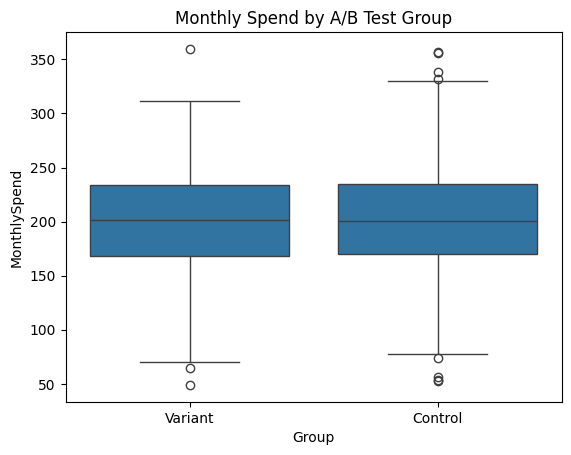

In [23]:
sns.boxplot(data=df, x='Group', y='MonthlySpend')
plt.title("Monthly Spend by A/B Test Group")
plt.show()

### Step 3: Hypothesis Testing - Independent T-test

In [24]:
control = df[df['Group'] == 'Control']['MonthlySpend']
variant = df[df['Group'] == 'Variant']['MonthlySpend']
t_stat, p_value = stats.ttest_ind(control, variant, equal_var=True)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")

T-statistic: 0.116, p-value: 0.908


**Interpretation:**
If p-value < 0.05, we reject the null hypothesis, indicating the variant caused a statistically significant change in Monthly Spend

## Sample Size Calculation

In [25]:
analysis = TTestIndPower()
effect_size = (210 - 200) / 50  # Small expected effect
sample_size = analysis.solve_power(effect_size=effect_size, power=0.8, alpha=0.05)
print(f"Required sample size per group to detect effect: {np.ceil(sample_size)}")

Required sample size per group to detect effect: 394.0


## Minimum Detectable Effect (MDE) & Margin of Error

- **MDE**: The smallest effect size we care to detect. Smaller MDE needs a larger sample.
- **Margin of Error** gives a range around the estimate; smaller margin = more precise result

# Conversion Rate Comparison

In [30]:
# Let's say each row also includes whether the user made a purchase (1) or not (0)
# We'll simulate a 'Converted' column for demonstration
np.random.seed(42)
df['Converted'] = np.where(df['Group'] == 'Control',
                           np.random.binomial(1, 0.12, len(df)),
                           np.random.binomial(1, 0.30, len(df)))  # Slightly better for Variant

In [31]:
# Step 1: Conversion rates for each group
conversion_rates = df.groupby('Group')['Converted'].mean()
print("Conversion Rates:\n", conversion_rates)

Conversion Rates:
 Group
Control    0.150
Variant    0.306
Name: Converted, dtype: float64


<ipython-input-32-b408204b5bc7>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Group', y='Converted', ci=None)


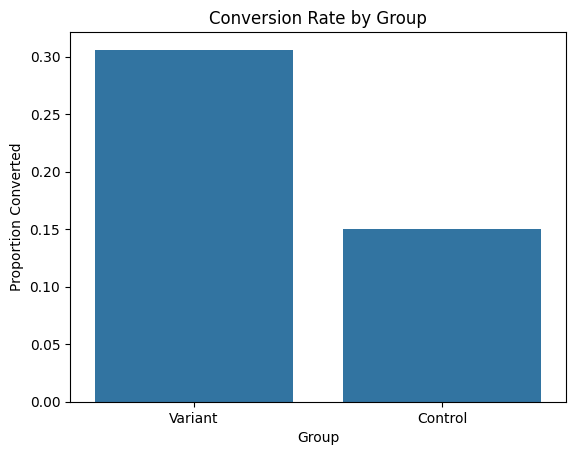

In [32]:
# Step 2: Visualize conversion rates
sns.barplot(data=df, x='Group', y='Converted', ci=None)
plt.title("Conversion Rate by Group")
plt.ylabel("Proportion Converted")
plt.show()

In [33]:
# Step 3: Hypothesis Test - Proportions Z-test
# H0: No difference in conversion rates
# H1: Difference in conversion rates

from statsmodels.stats.proportion import proportions_ztest

count = df.groupby('Group')['Converted'].sum().values
nobs = df['Group'].value_counts().sort_index().values
z_stat, pval = proportions_ztest(count, nobs)
print(f"Z-statistic: {z_stat:.3f}, p-value: {pval:.3f}")

Z-statistic: -5.879, p-value: 0.000


# Understanding Metrics

- p-hacking: Manipulating data or repeating tests until significant p-values appear (avoid this!)
- Guardrail metrics: Metrics that shouldn't worsen (e.g., customer satisfaction, drop-off rate)
- Success metrics: Primary goal/KPI of the experiment (e.g., increase in revenue or conversion)

# HYPOTHESIS TESTING

Hypothesis testing is a fundamental part of statistical inference
We choose tests based on:
- Data type (numeric or categorical)
- Number of groups
- Normality of data
- Equality of variances

## Normality Test: Shapiro-Wilk

In [34]:
print("Shapiro-Wilk Test for Control:", stats.shapiro(control))
print("Shapiro-Wilk Test for Variant:", stats.shapiro(variant))

Shapiro-Wilk Test for Control: ShapiroResult(statistic=np.float64(0.9973453247035902), pvalue=np.float64(0.60719248522456))
Shapiro-Wilk Test for Variant: ShapiroResult(statistic=np.float64(0.9977181958935859), pvalue=np.float64(0.7375612552653691))


**Note:** If p > 0.05, the data is likely normal

## Homogeneity of Variance Test: Levene's

In [35]:
print("Levene's Test for Equal Variance:", stats.levene(control, variant))

Levene's Test for Equal Variance: LeveneResult(statistic=np.float64(0.04757094423732923), pvalue=np.float64(0.8273898299229072))


**Note:** If p > 0.05, we assume equal variances (safe to use t-test with equal_var=True)

## One Sample t-test

In [ ]:
result = stats.ttest_1samp(df['MonthlySpend'], 190)
print("One Sample t-test against $190:", result)

The one-sample t-test shows that the average MonthlySpend is significantly different from $190 (p < 0.001), so we reject the null hypothesis.

## ANOVA: Compare More Than Two Groups

In [36]:
anova_result = stats.f_oneway(
    df[df['ProductCategory'] == 'Grocery']['MonthlySpend'],
    df[df['ProductCategory'] == 'Electronics']['MonthlySpend'],
    df[df['ProductCategory'] == 'Clothing']['MonthlySpend']
)
print("ANOVA result (ProductCategory vs MonthlySpend):", anova_result)

ANOVA result (ProductCategory vs MonthlySpend): F_onewayResult(statistic=np.float64(0.10725437976850352), pvalue=np.float64(0.8983074985366845))


## Chi-Square Test of Independence

In [37]:
contingency = pd.crosstab(df['Gender'], df['PromoUsed'])
contingency

PromoUsed,No,Yes
Gender,,
Female,305,206
Male,284,205


In [38]:
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print("Chi-square Test of Independence (Gender vs PromoUsed):", chi2, p)

Chi-square Test of Independence (Gender vs PromoUsed): 0.20494870297754417 0.6507557015820429


The Chi-square test indicates that there is no significant association between Gender and PromoUsed (p = 0.651).

## Non-parametric Tests (if data isn't normal)

### Mann-Whitney U Test - Alternative to t-test for independent groups

In [39]:
mann_whitney = stats.mannwhitneyu(control, variant)
print("Mann-Whitney U Test (Control vs Variant):", mann_whitney)

Mann-Whitney U Test (Control vs Variant): MannwhitneyuResult(statistic=np.float64(124803.0), pvalue=np.float64(0.9656780282775731))


The Mann-Whitney U test shows no significant difference between the Control and Variant groups (p = 0.966).

### Kruskal-Wallis Test - Non-parametric ANOVA

In [40]:
kruskal_result = stats.kruskal(
    df[df['ProductCategory'] == 'Grocery']['MonthlySpend'],
    df[df['ProductCategory'] == 'Electronics']['MonthlySpend'],
    df[df['ProductCategory'] == 'Clothing']['MonthlySpend']
)
print("Kruskal-Wallis Test (ProductCategory):", kruskal_result)

Kruskal-Wallis Test (ProductCategory): KruskalResult(statistic=np.float64(0.30881751249344525), pvalue=np.float64(0.8569216773251916))


The Kruskal-Wallis test indicates no significant difference in Monthly Spend across different Product Categories (p = 0.857).

### Wilcoxon Signed-Rank Test - For paired samples (e.g. before and after)

In [41]:
before = df['MonthlySpend']
after = before + np.random.normal(5, 10, size=len(before))
wilcoxon_result = stats.wilcoxon(before, after)
print("Wilcoxon Signed-Rank Test (Before vs After):", wilcoxon_result)

Wilcoxon Signed-Rank Test (Before vs After): WilcoxonResult(statistic=np.float64(114031.0), pvalue=np.float64(2.8011647461539606e-50))


The Wilcoxon Signed-Rank Test shows a highly significant difference between the "Before" and "After" conditions, with a p-value close to zero.

## Correlation Test: Pearson

In [42]:
correlation, pval = stats.pearsonr(df['Age'], df['MonthlySpend'])
print("Pearson Correlation (Age vs MonthlySpend):", correlation, pval)

Pearson Correlation (Age vs MonthlySpend): -0.012075274412161765 0.7029138669051183


**Interpretation:**
- A positive coefficient close to 1 = strong positive relationship
- A p-value < 0.05 = significant correlation

# Summary

✅ Always check assumptions (normality, homogeneity)
✅ Choose tests based on assumptions and data types
✅ Interpret p-values in the context of the problem
✅ Use both visual and statistical tools for validation
✅ Avoid p-hacking; use clear hypotheses and metrics